In [1]:
from __future__ import division
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score

from composition.analysis.load_sim import load_sim
from composition.analysis.preprocessing import get_train_test_sets, LabelEncoder
from composition.analysis.pipelines import get_pipeline
from composition.analysis.plotting_functions import plot_decision_regions
import composition.analysis.data_functions as data_functions
from composition.support_functions.checkdir import checkdir

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sns.set_palette('muted')
sns.set_color_codes()

In [3]:
df, cut_dict = load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits', 'IT_signal', 'StationDensity',
                     'max_charge_frac', 'reco_containment', 'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list = np.array(['reco_log_energy', 'InIce_log_charge'])
X_train, X_test, y_train, y_test, le = get_train_test_sets(df, feature_list)

print('events = ' + str(y_train.shape[0]))

/home/jbourbeau/composition/analysis/load_sim.py:41: RuntimeWarning: divide by zero encountered in log10
  cut_dict['min_energy'] = (np.log10(df['reco_energy']) > 6.2)
/home/jbourbeau/composition/analysis/load_sim.py:42: RuntimeWarning: divide by zero encountered in log10
  cut_dict['max_energy'] = (np.log10(df['reco_energy']) < 8.0)
/home/jbourbeau/composition/analysis/load_sim.py:63: RuntimeWarning: divide by zero encountered in log10
  df['reco_log_energy'] = np.nan_to_num(np.log10(df['reco_energy']))
/home/jbourbeau/composition/analysis/load_sim.py:64: RuntimeWarning: invalid value encountered in log10
  df['InIce_log_charge'] = np.nan_to_num(np.log10(df['InIce_charge']))


events = 72644


[CV] classifier__n_neighbors=10 ......................................
[CV] classifier__n_neighbors=210 .....................................
[CV] classifier__n_neighbors=410 .....................................
[CV] classifier__n_neighbors=610 .....................................
[CV] classifier__n_neighbors=810 .....................................
[CV] classifier__n_neighbors=1010 ....................................
[CV] classifier__n_neighbors=1210 ....................................
[CV] classifier__n_neighbors=1410 ....................................
[CV] classifier__n_neighbors=1610 ....................................
[CV] classifier__n_neighbors=1810 ....................................
[CV] ............. classifier__n_neighbors=10, score=0.707689 -   0.1s
[CV] classifier__n_neighbors=10 ......................................
[CV] ............. classifier__n_neighbors=10, score=0.706829 -   0.2s
[CV] classifier__n_neighbors=210 .....................................
[CV] .

[Parallel(n_jobs=10)]: Done  17 out of  50 | elapsed:   48.5s remaining:  1.6min


[CV] ............ classifier__n_neighbors=410, score=0.732805 -  11.7s
[CV] classifier__n_neighbors=1410 ....................................
[CV] ........... classifier__n_neighbors=1210, score=0.730165 -   5.5s
[CV] classifier__n_neighbors=1610 ....................................
[CV] ........... classifier__n_neighbors=1610, score=0.728568 -   8.2s
[CV] classifier__n_neighbors=1810 ....................................
[CV] ........... classifier__n_neighbors=1410, score=0.729366 -   6.6s
[CV] classifier__n_neighbors=10 ......................................
[CV] ............ classifier__n_neighbors=610, score=0.732621 -  13.2s
[CV] classifier__n_neighbors=210 .....................................
[CV] ............. classifier__n_neighbors=10, score=0.713443 -   0.1s
[CV] classifier__n_neighbors=410 .....................................
[CV] ............ classifier__n_neighbors=210, score=0.736658 -   1.3s
[CV] classifier__n_neighbors=610 .....................................
[CV] .

[Parallel(n_jobs=10)]: Done  34 out of  50 | elapsed:  1.4min remaining:   38.7s


[CV] ............ classifier__n_neighbors=210, score=0.733694 -   1.1s
[CV] classifier__n_neighbors=810 .....................................
[CV] ........... classifier__n_neighbors=1010, score=0.733956 -   3.9s
[CV] classifier__n_neighbors=1010 ....................................
[CV] ........... classifier__n_neighbors=1610, score=0.727708 -   8.0s
[CV] classifier__n_neighbors=1210 ....................................
[CV] ............ classifier__n_neighbors=410, score=0.731544 -   2.7s
[CV] classifier__n_neighbors=1410 ....................................
[CV] ........... classifier__n_neighbors=1210, score=0.733956 -   5.1s
[CV] classifier__n_neighbors=1610 ....................................
[CV] ............ classifier__n_neighbors=610, score=0.730193 -   2.2s
[CV] classifier__n_neighbors=1810 ....................................
[CV] ........... classifier__n_neighbors=1410, score=0.733710 -   9.6s
[CV] ............ classifier__n_neighbors=810, score=0.730746 -   4.9s
[CV] .

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  2.2min finished


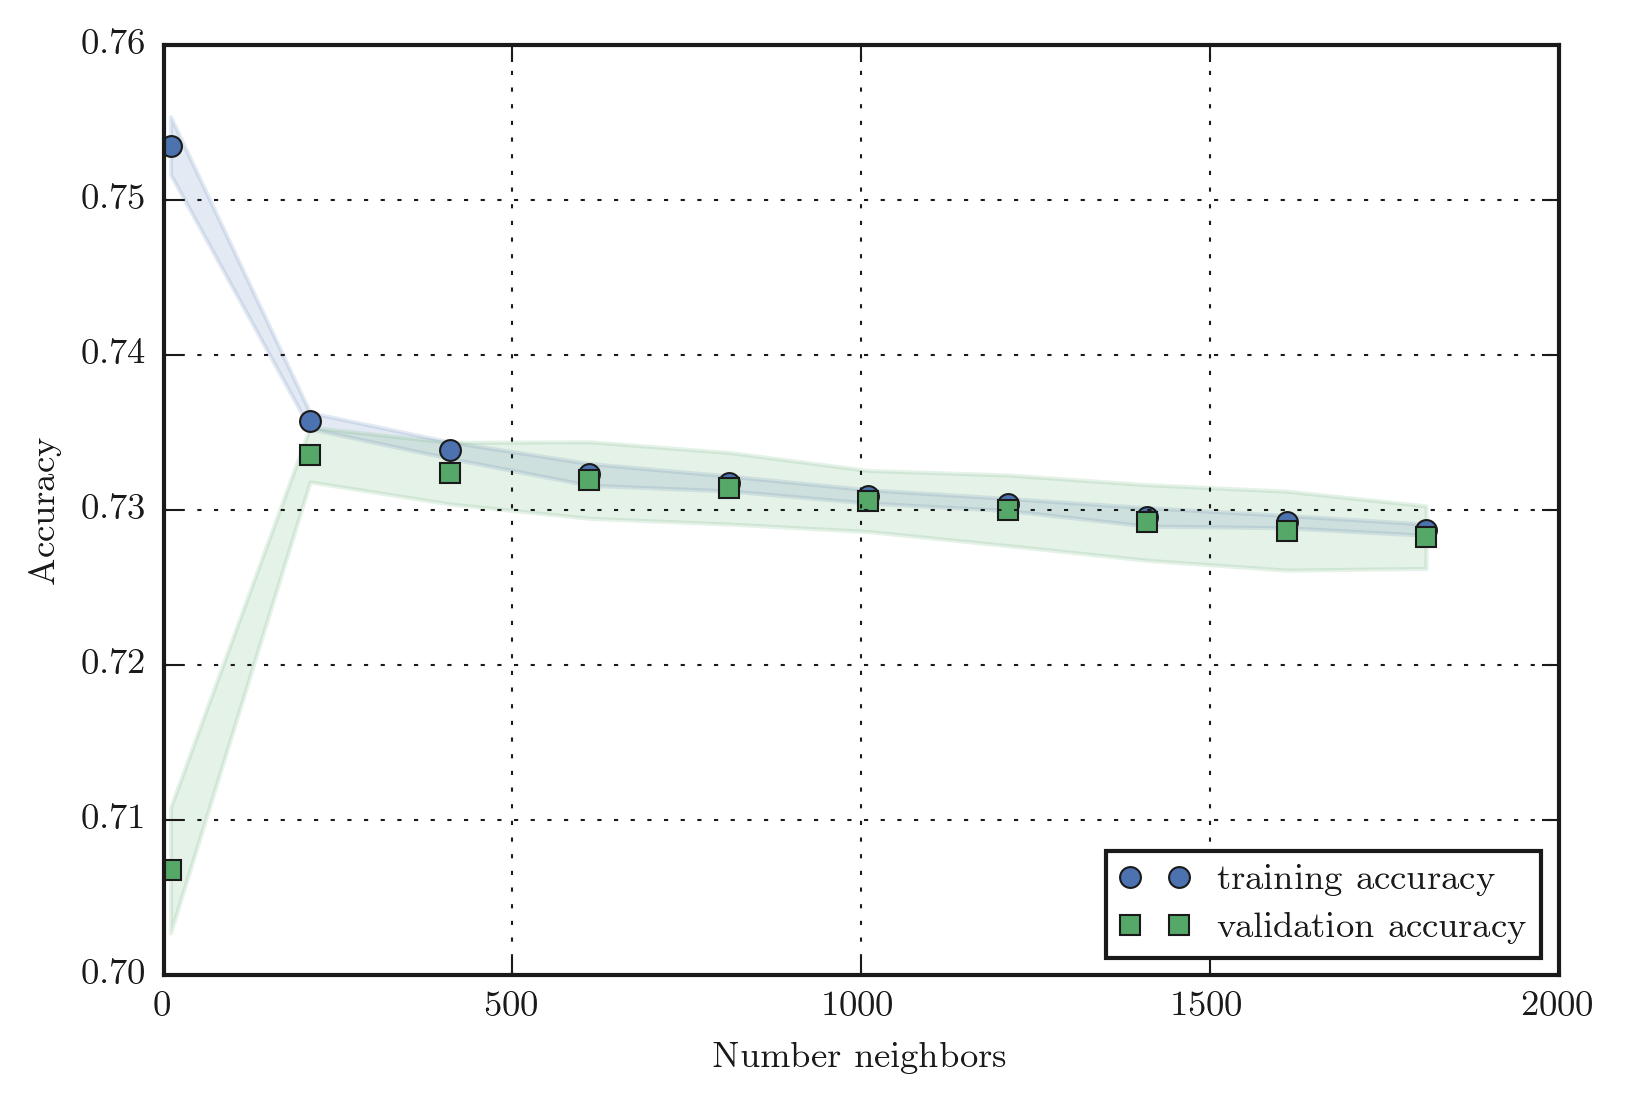

In [6]:
pipeline = get_pipeline('KN')
param_range = np.arange(10, 2000, 200)
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=X_train, 
                y=y_train, 
                param_name='classifier__n_neighbors', 
                param_range=param_range,
                cv=5,
                verbose=3,
                n_jobs=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='b', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='b')

plt.plot(param_range, test_mean, 
         color='g', linestyle='None', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='g')

plt.grid()
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Number neighbors')
plt.ylabel('Accuracy')
# plt.ylim([0.8, 1.0])
# plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()